## Часть 2. Детекция шлемов.

В этой части задания нужно получить модель детекции шлемов. В качестве изображений для обучения используйте фреймы, уже выделенные организаторами соревнования в папке `images/`, а также соответствующую им разметку для шлемов `image_labels.csv`. 

*Этапы работы*
1. Выделить обучающую и валидационную части на данных для обучения.
2. Провести несколько различных экспериментов по обучению одного или нескольких вариантов детекционных моделей. Выделить лучшую  модель по валидации по метрике mAP.
3. Выделить фреймы для нескольких видео (чем больше получится взять, тем лучше) из папки `train`. Сравнить mAP между результатами ваше модели и результатами модели, которые опубликованы в соревновании. 
4. Сделать выводы.

*Примечание*

Хороший пример с детекцией есть [тут](https://www.kaggle.com/code/ammarnassanalhajali/nfl-training-and-inference-yolov5). 

In [98]:
import os
from IPython.display import clear_output, Video, display
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from shutil import copyfile
import yaml
import gc
import cv2
from kaggle_secrets import UserSecretsClient
import wandb
from PIL import Image

!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%cd ../
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

clear_output()

*Гиперпараметры:*

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_TRAIN_PATH = "/kaggle/input/nfl-health-and-safety-helmet-assignment/images"
LABELS_TRAIN_PATH = "/kaggle/input/nfl-health-and-safety-helmet-assignment/image_labels.csv"
IMG_SIZE = 720
BATCH_SIZE = 16
EPOCHS = 10

*Для начала попробую модель YOLO5. Подготовим необходимые ей данные и датасет с лейблами*

In [4]:
image_labels_df = pd.read_csv(LABELS_TRAIN_PATH)
image_labels_df.head()

,image,label,left,width,top,height
0,57503_000116_Endzone_frame443.jpg,Helmet,1099,16,456,15
1,57503_000116_Endzone_frame443.jpg,Helmet,1117,15,478,16
2,57503_000116_Endzone_frame443.jpg,Helmet,828,16,511,15
3,57503_000116_Endzone_frame443.jpg,Helmet,746,16,519,16
4,57503_000116_Endzone_frame443.jpg,Helmet,678,17,554,17


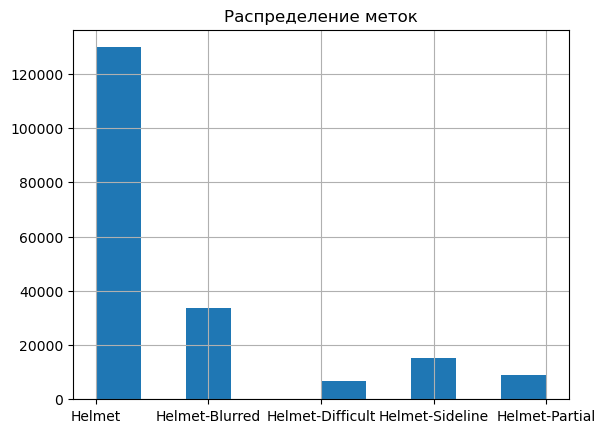

In [5]:
image_labels_df.label.hist()
plt.title("Распределение меток");

*Разделим датасет так, чтобы в трейне и валидации оставалось одинаковое распределение меток. При этом одни и те же изображения попадать в оба датасета не должны*

In [6]:
unique_images = image_labels_df["image"].unique()
train_df, val_df = train_test_split(
    unique_images,
    test_size=0.2,
    random_state=42,
    stratify=image_labels_df.groupby("image")["label"].apply(lambda x: x.iloc[0]),
)

train_df = image_labels_df[image_labels_df["image"].isin(train_df)].reset_index()
val_df = image_labels_df[image_labels_df["image"].isin(val_df)].reset_index()

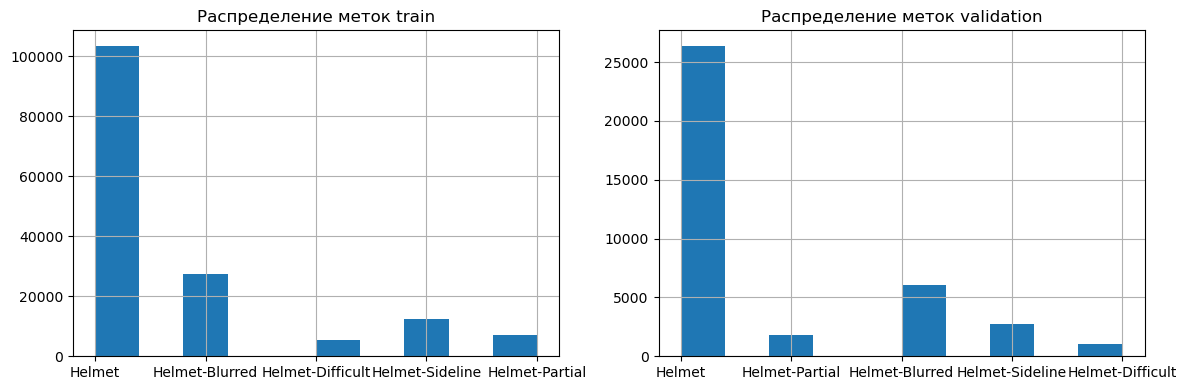

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
train_df["label"].hist(ax=axs[0])
val_df["label"].hist(ax=axs[1])
axs[0].set_title("Распределение меток train")
axs[1].set_title("Распределение меток validation")
plt.tight_layout()

*Подготовим файловую структуру которую трубует YOLO*

In [8]:
os.makedirs("tmp/yolo_workdir/images/train", exist_ok=True)
os.makedirs("tmp/yolo_workdir/images/valid", exist_ok=True)
os.makedirs("tmp/yolo_workdir/labels/train", exist_ok=True)
os.makedirs("tmp/yolo_workdir/labels/valid", exist_ok=True)


for img_name in tqdm(train_df.image.unique()):
    copyfile(
        f"{IMG_TRAIN_PATH}/{img_name}", f"tmp/yolo_workdir/images/train/{img_name}"
    )

for img_name in tqdm(val_df.image.unique()):
    copyfile(
        f"{IMG_TRAIN_PATH}/{img_name}", f"tmp/yolo_workdir/images/valid/{img_name}"
    )

100%|██████████| 1990/1990 [00:11<00:00, 173.76it/s]


*Подготовим конфигурационный YAML файл*

In [9]:
data_yaml = dict(
    train="/kaggle/working/tmp/yolo_workdir/images/train",
    val="/kaggle/working/tmp/yolo_workdir/images/valid",
    nc=5, # количество классов
    names=list(image_labels_df["label"].unique()),
)

with open("/kaggle/working/yolov5/data/data.yaml", "w") as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

*Сделаем файлы координат bounding box-ов в YOLO-формате*

In [10]:
def get_yolo_format_bbox(img_w, img_h, box):
    w = box.width  # width
    h = box.height  # height
    xc = box.left + int(np.round(w / 2))  # xmin + width/2
    yc = box.top + int(np.round(h / 2))  # ymin + height/2

    return [
        xc / img_w,
        yc / img_h,
        w / img_w,
        h / img_h,
    ]  # x_center y_center width height

image_bbox_label = {}
for image, df in image_labels_df.groupby('image'): 
    image_bbox_label[image] = df.reset_index(drop=True)
label_to_id = {label: i for i, label in enumerate(image_labels_df.label.unique())}

# Iterate over each image and write the labels and bbox coordinates to a .txt file.
for img_name, df in tqdm(image_bbox_label.items()):
    # open image file to get the height and width
    img = cv2.imread(IMG_TRAIN_PATH + "/" + img_name)
    height, width, _ = img.shape

    # iterate over bounding box df
    bboxes = []
    for i in range(len(df)):
        # get a row
        box = df.loc[i]
        # get bbox in YOLO format
        box = get_yolo_format_bbox(width, height, box)
        bboxes.append(box)

    if img_name in train_df.image.unique():
        img_name = img_name[:-4]
        file_name = f"/kaggle/working/tmp/yolo_workdir/labels/train/{img_name}.txt"
    elif img_name in val_df.image.unique():
        img_name = img_name[:-4]
        file_name = f"/kaggle/working/tmp/yolo_workdir/labels/valid/{img_name}.txt"

    with open(file_name, "w") as f:
        for i, bbox in enumerate(bboxes):
            label = label_to_id[df.loc[i].label]
            bbox = [label] + bbox
            bbox = [str(i) for i in bbox]
            bbox = " ".join(bbox)
            f.write(bbox)
            f.write("\n")

100%|██████████| 9947/9947 [05:58<00:00, 27.72it/s]


*Примечание: последние 3 пункта с небольшими изменениями я взяла из [kaggle ноутбука](https://www.kaggle.com/code/ayuraj/train-nfl-extra-images-yolov5-with-w-b), так как это просто технический код*

In [11]:
%ls /kaggle/working/yolov5/models

__init__.py      hub/      yolo.py       yolov5n.yaml
common.py        segment/  yolov5l.yaml  yolov5s.yaml
experimental.py  tf.py     yolov5m.yaml  yolov5x.yaml


*Для визуализации буду использовать Weights and Biases, как в приведенном ноутбуке. Визуализации и значения метрик буду брать готовые из онлайн-панели*

In [12]:
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wab") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

*Обучим модель YOLOv5s - вторую по размеру из таблицы проекта на гитхабе. Начнем с самой базовой модели. Единственное что изменю это количество эпох, так как дефолтные 300 - слишком долго для моего исследования*

In [ ]:
!python /kaggle/working/yolov5/train.py \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project helmet_detection_base \
                 --save-period 1

*Замечу, что метрики в YOLO считаются по валидации, как нам и нужно*

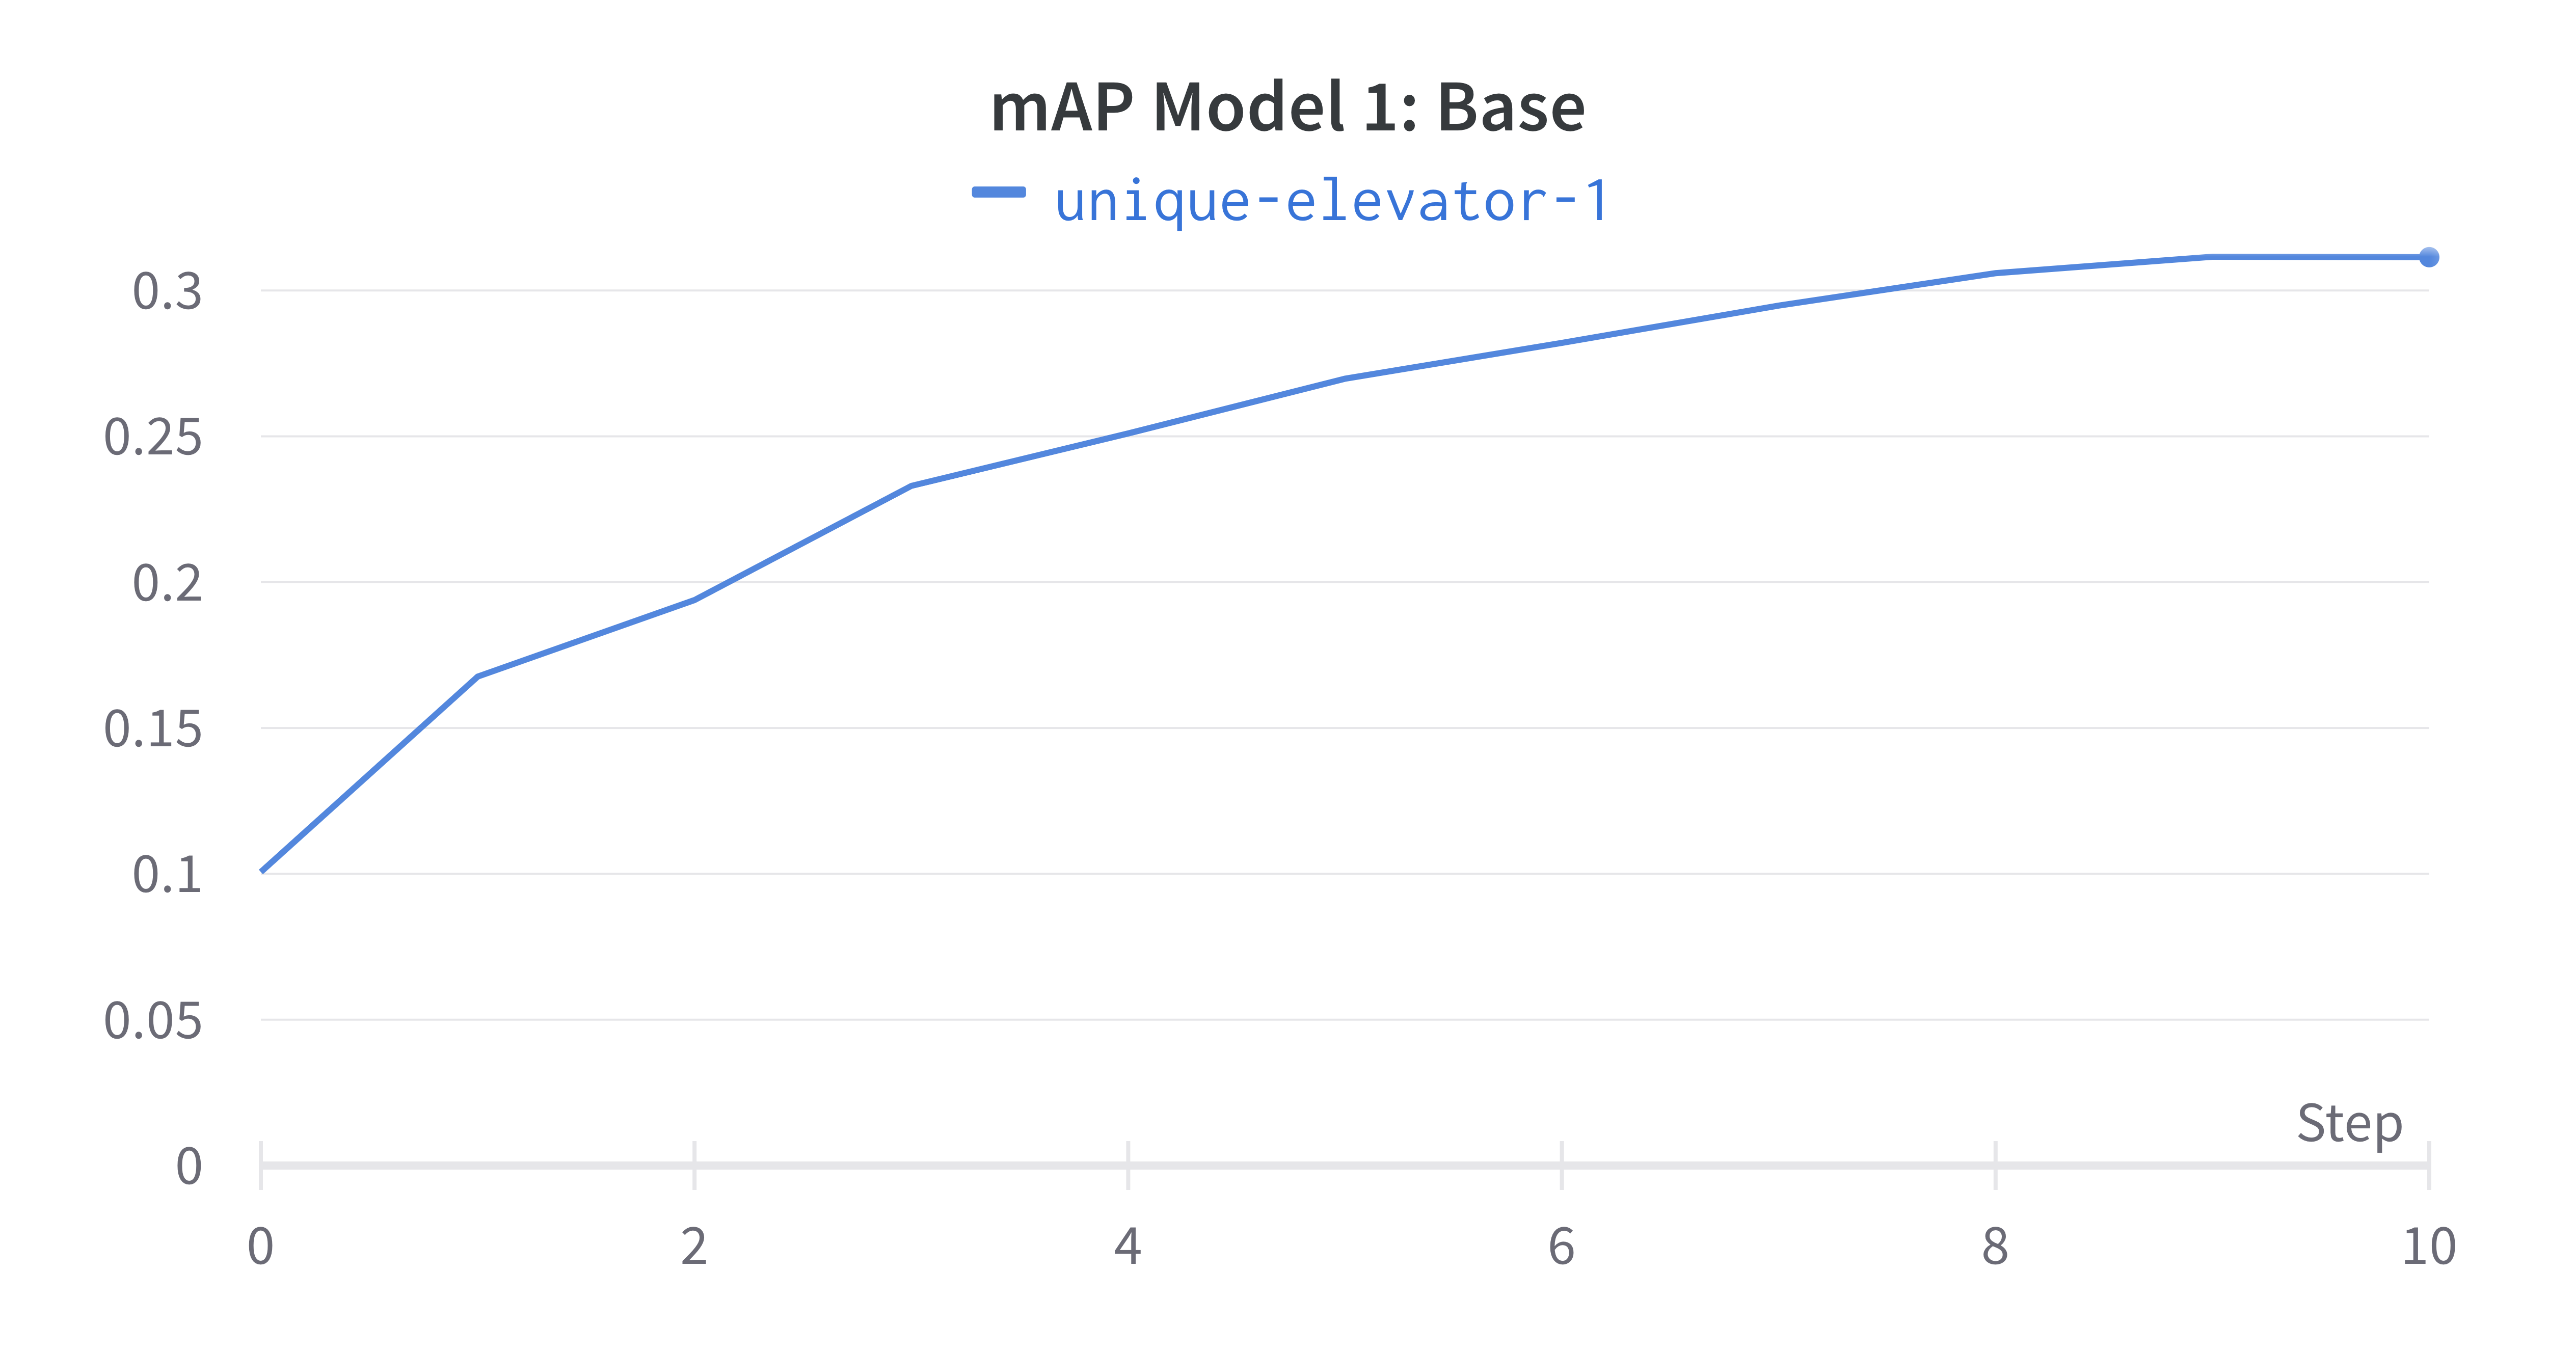

*Результаты: https://wandb.ai/liza-i-pivko/helmet_detection_base/reports/YOLOv5-Base--VmlldzozNjU0ODM3?accessToken=4wl8t4aivsutgnczjdvcd631td793lvqp6ssqjd3ijm7bg0iri6m47le3bml41oc*

***Для базовой модели на 10 эпохе mAP = 0.31***

*Попробуем увеличить image size*

In [ ]:
!python /kaggle/working/yolov5/train.py --img 1024 \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project helmet_detection \
                 --save-period 1 \
                 --device=0

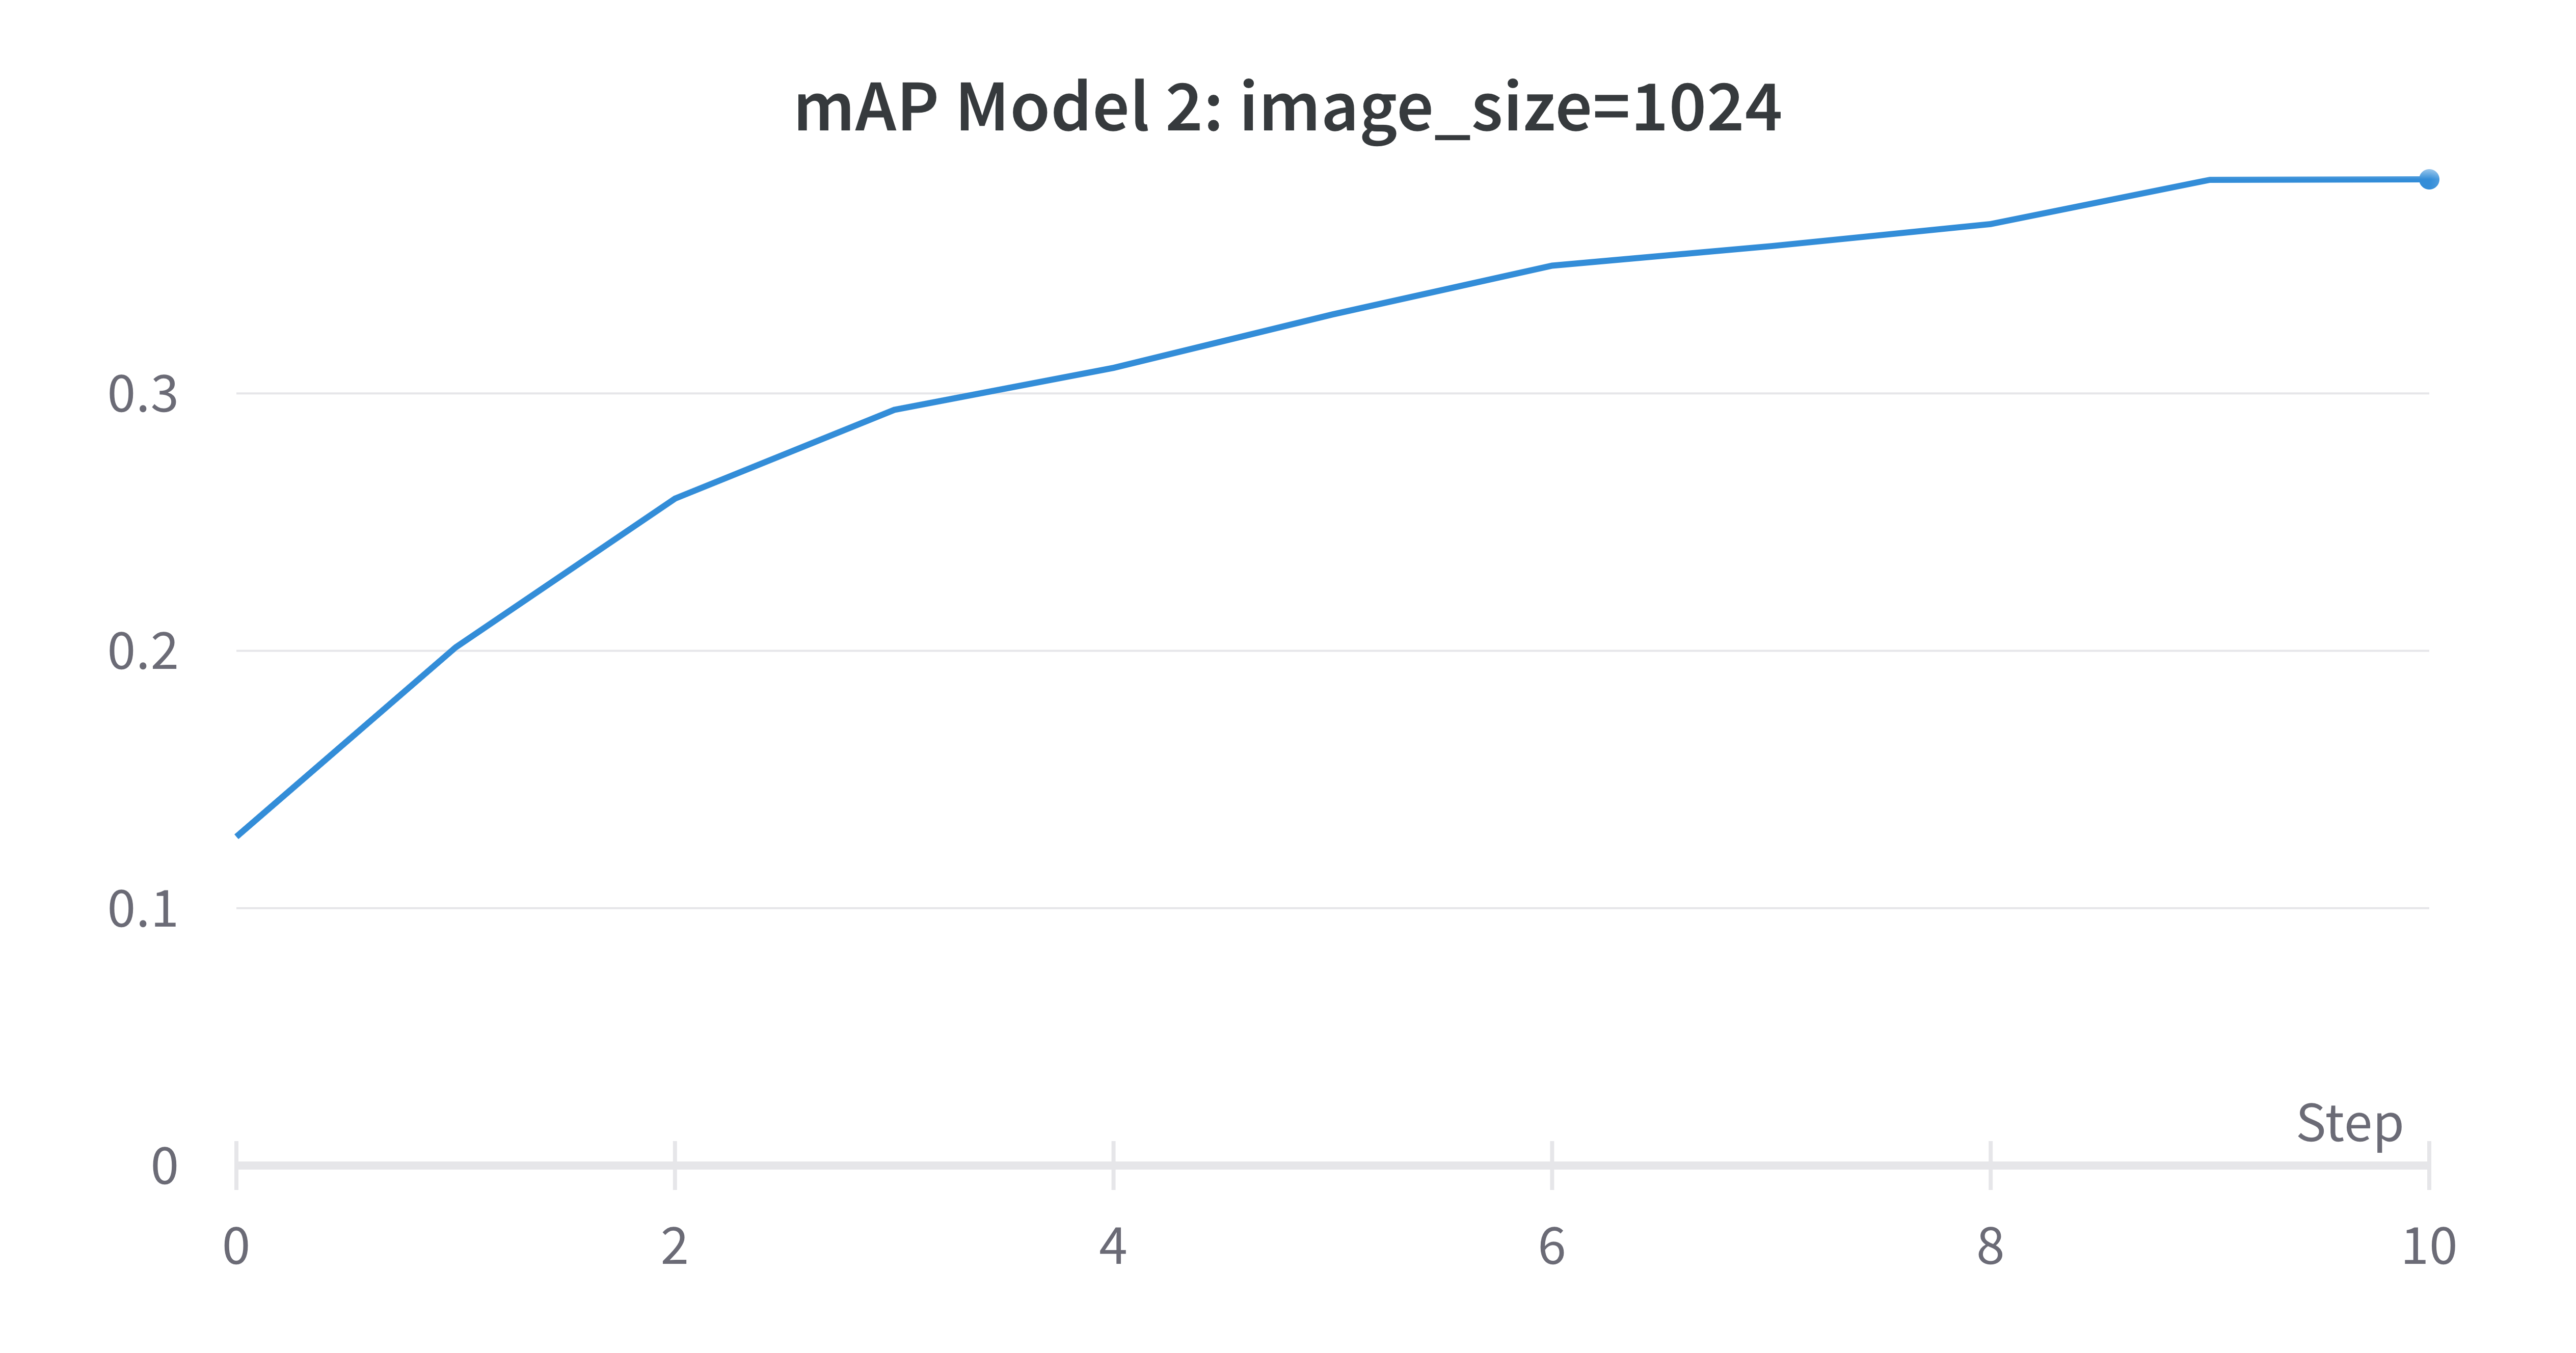

*Результаты: https://wandb.ai/liza-i-pivko/helmet_detection/reports/YOLOv5-image-size-1024--VmlldzozNjU0ODk3?accessToken=1r1bybc16m3tfy7x59z50zq17ym5jrj1kqref02kchulv8la08adzgnlpddalp1d*

***На 10 эпохе mAP = 0.383***

*Значение mAP увеличилось до 0.38, а на превалирующем классе Helmet - до 0.57. Это уже неплохо. Попробую также изменить оптимизатор SGD на Adam, при этом понизив в 10 раз learning rate, как это рекомендуют в мануалах YOLO*

In [37]:
with open('/kaggle/working/yolov5/data/hyps/hyp.scratch-low.yaml', 'r') as source_file:
    data = yaml.load(source_file, Loader=yaml.FullLoader)
    data['lr0'] = 1e-3
    data['lrf'] = 1e-3
    
with open('/kaggle/working/yolov5/data/hyps/hyp.adam.yaml', 'w') as destination_file:
    yaml.dump(data, destination_file)

In [ ]:
!python /kaggle/working/yolov5/train.py --img 1024 \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project helmet_detection_adam \
                 --save-period 1 \
                 --device=0 \
                 --optimizer Adam \
                 --hyp /kaggle/working/yolov5/data/hyps/hyp.adam.yaml

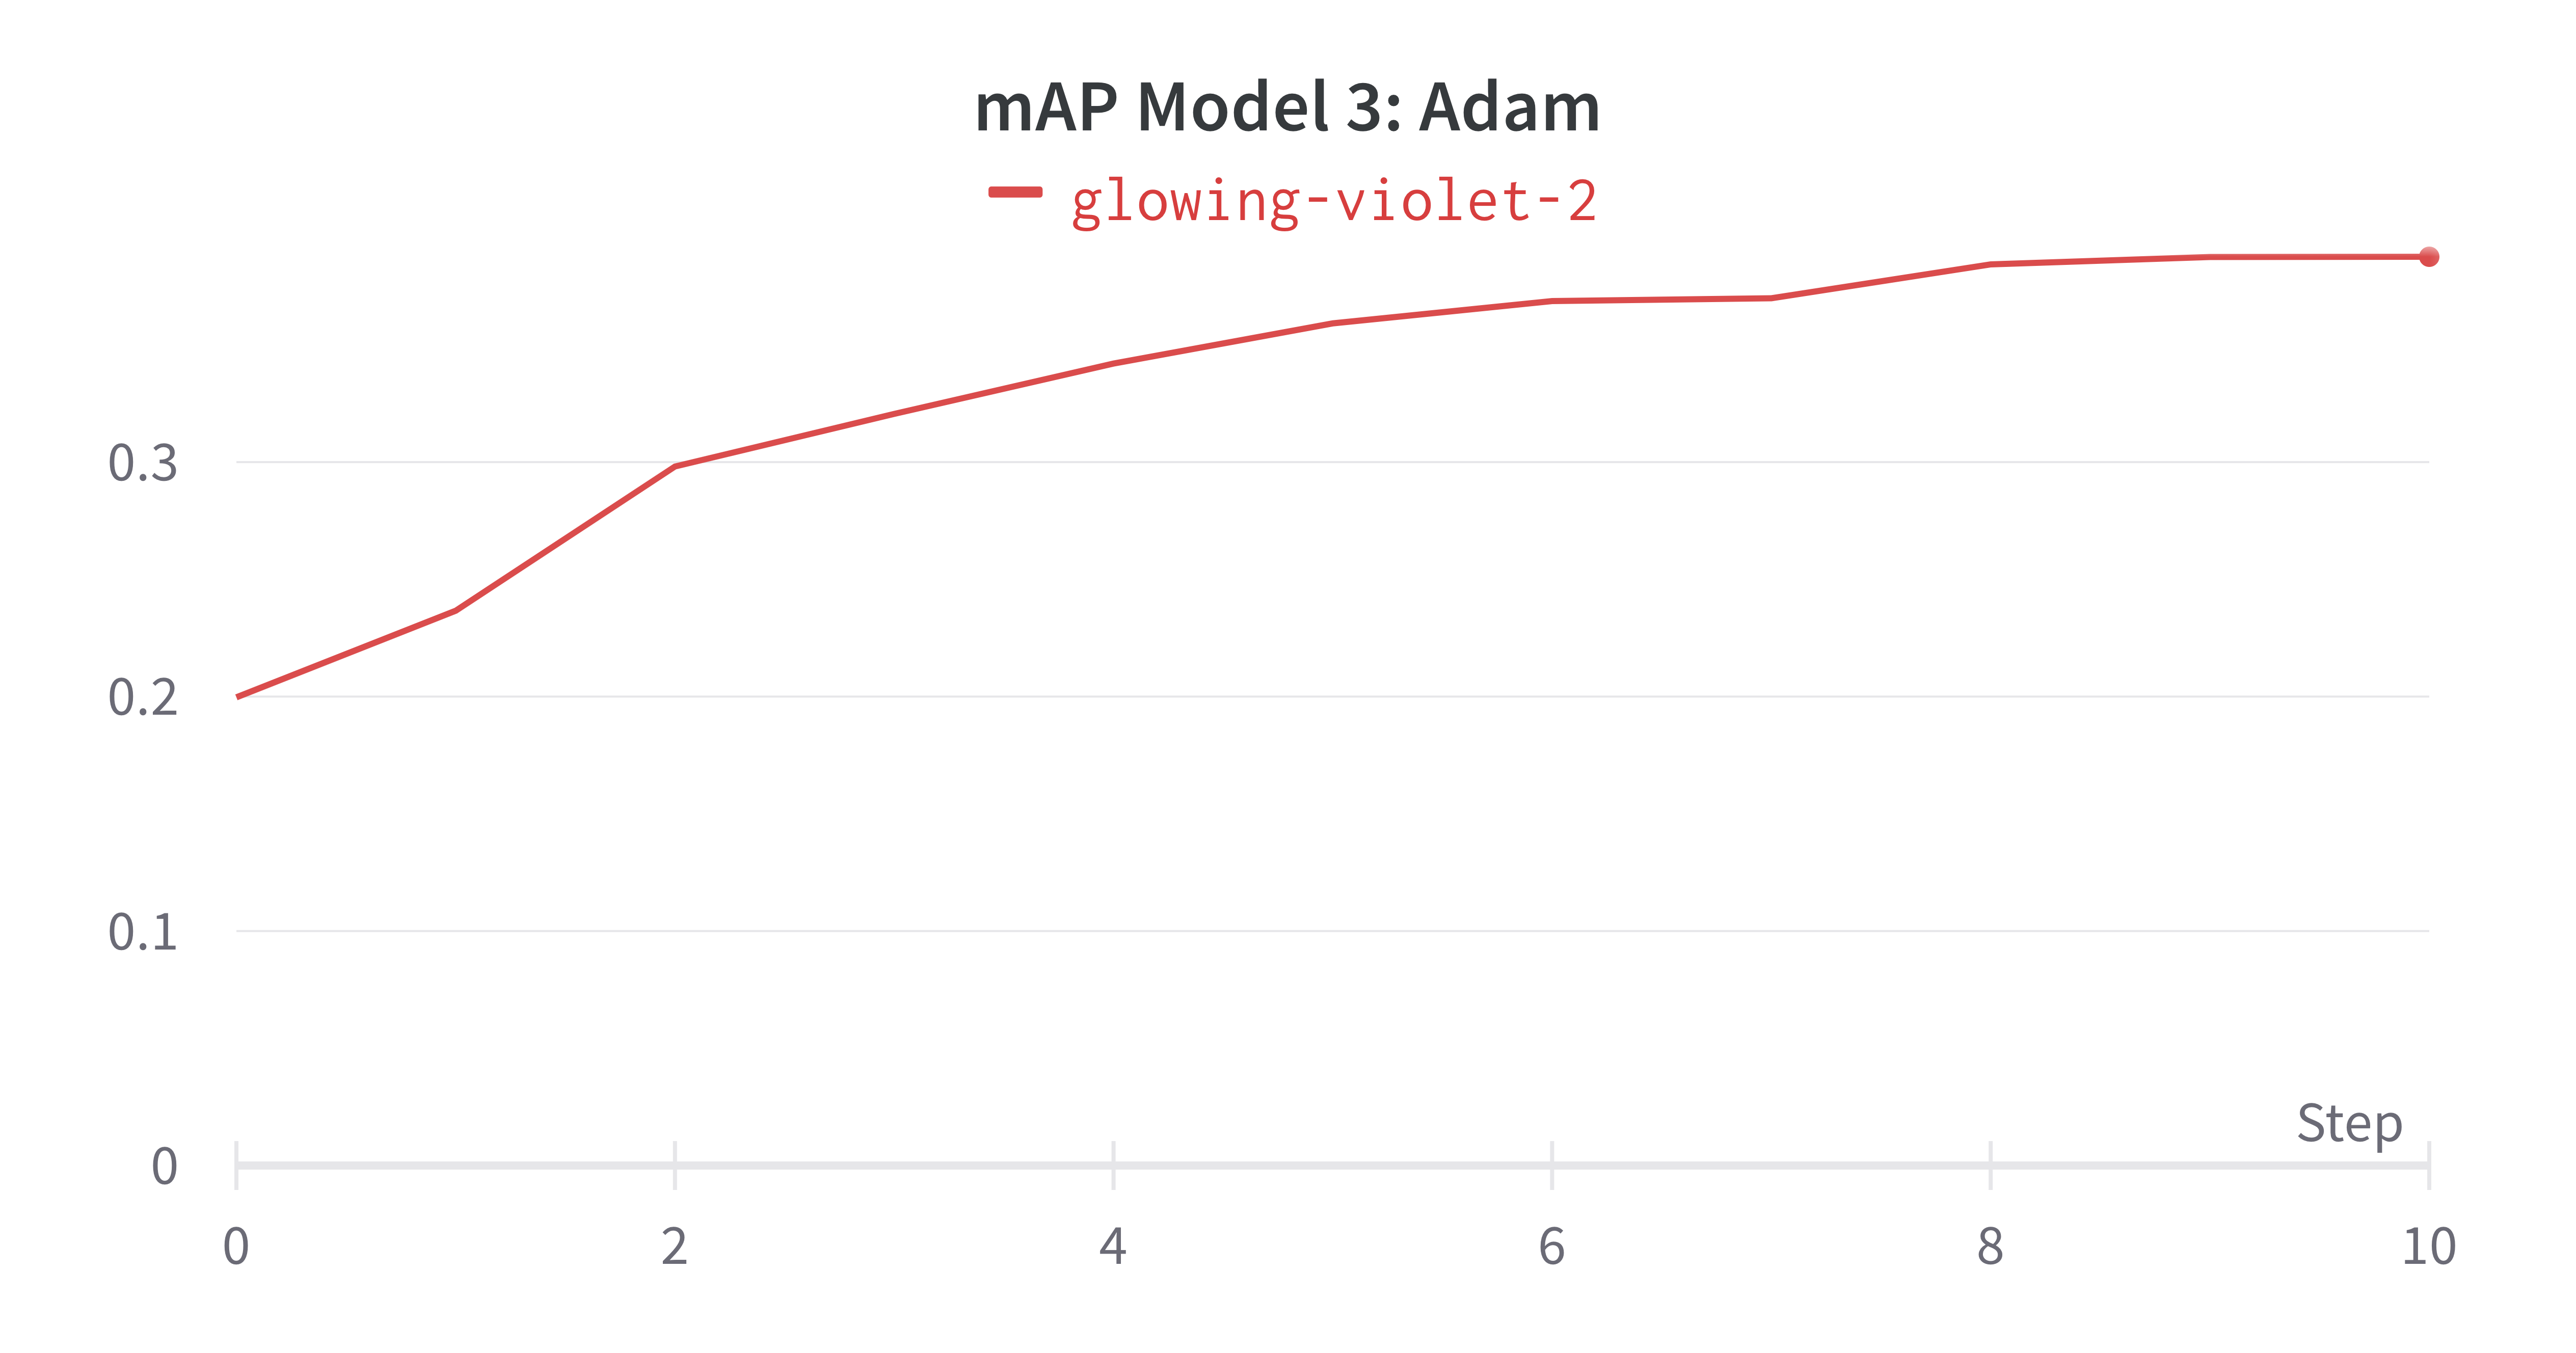

*Результаты: https://wandb.ai/liza-i-pivko/helmet_detection_adam/reports/YOLOv5-Adam--VmlldzozNjU1NDk1?accessToken=mjtwrxf7u391dgwtxhnq6qgvwwsxai4gsrkwb6pgf0wam4a125y71dvy64qabort*

***На 10 эпохе mAP = 0.387***

*Значительного улучшения не получилось. Оставим SGD оптимизатор и обучим с бОльшим размером батча*

In [ ]:
!python /kaggle/working/yolov5/train.py --img 1024 \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project helmet_detection_batch \
                 --save-period 1 \
                 --device=0 \
                 --batch-size=32

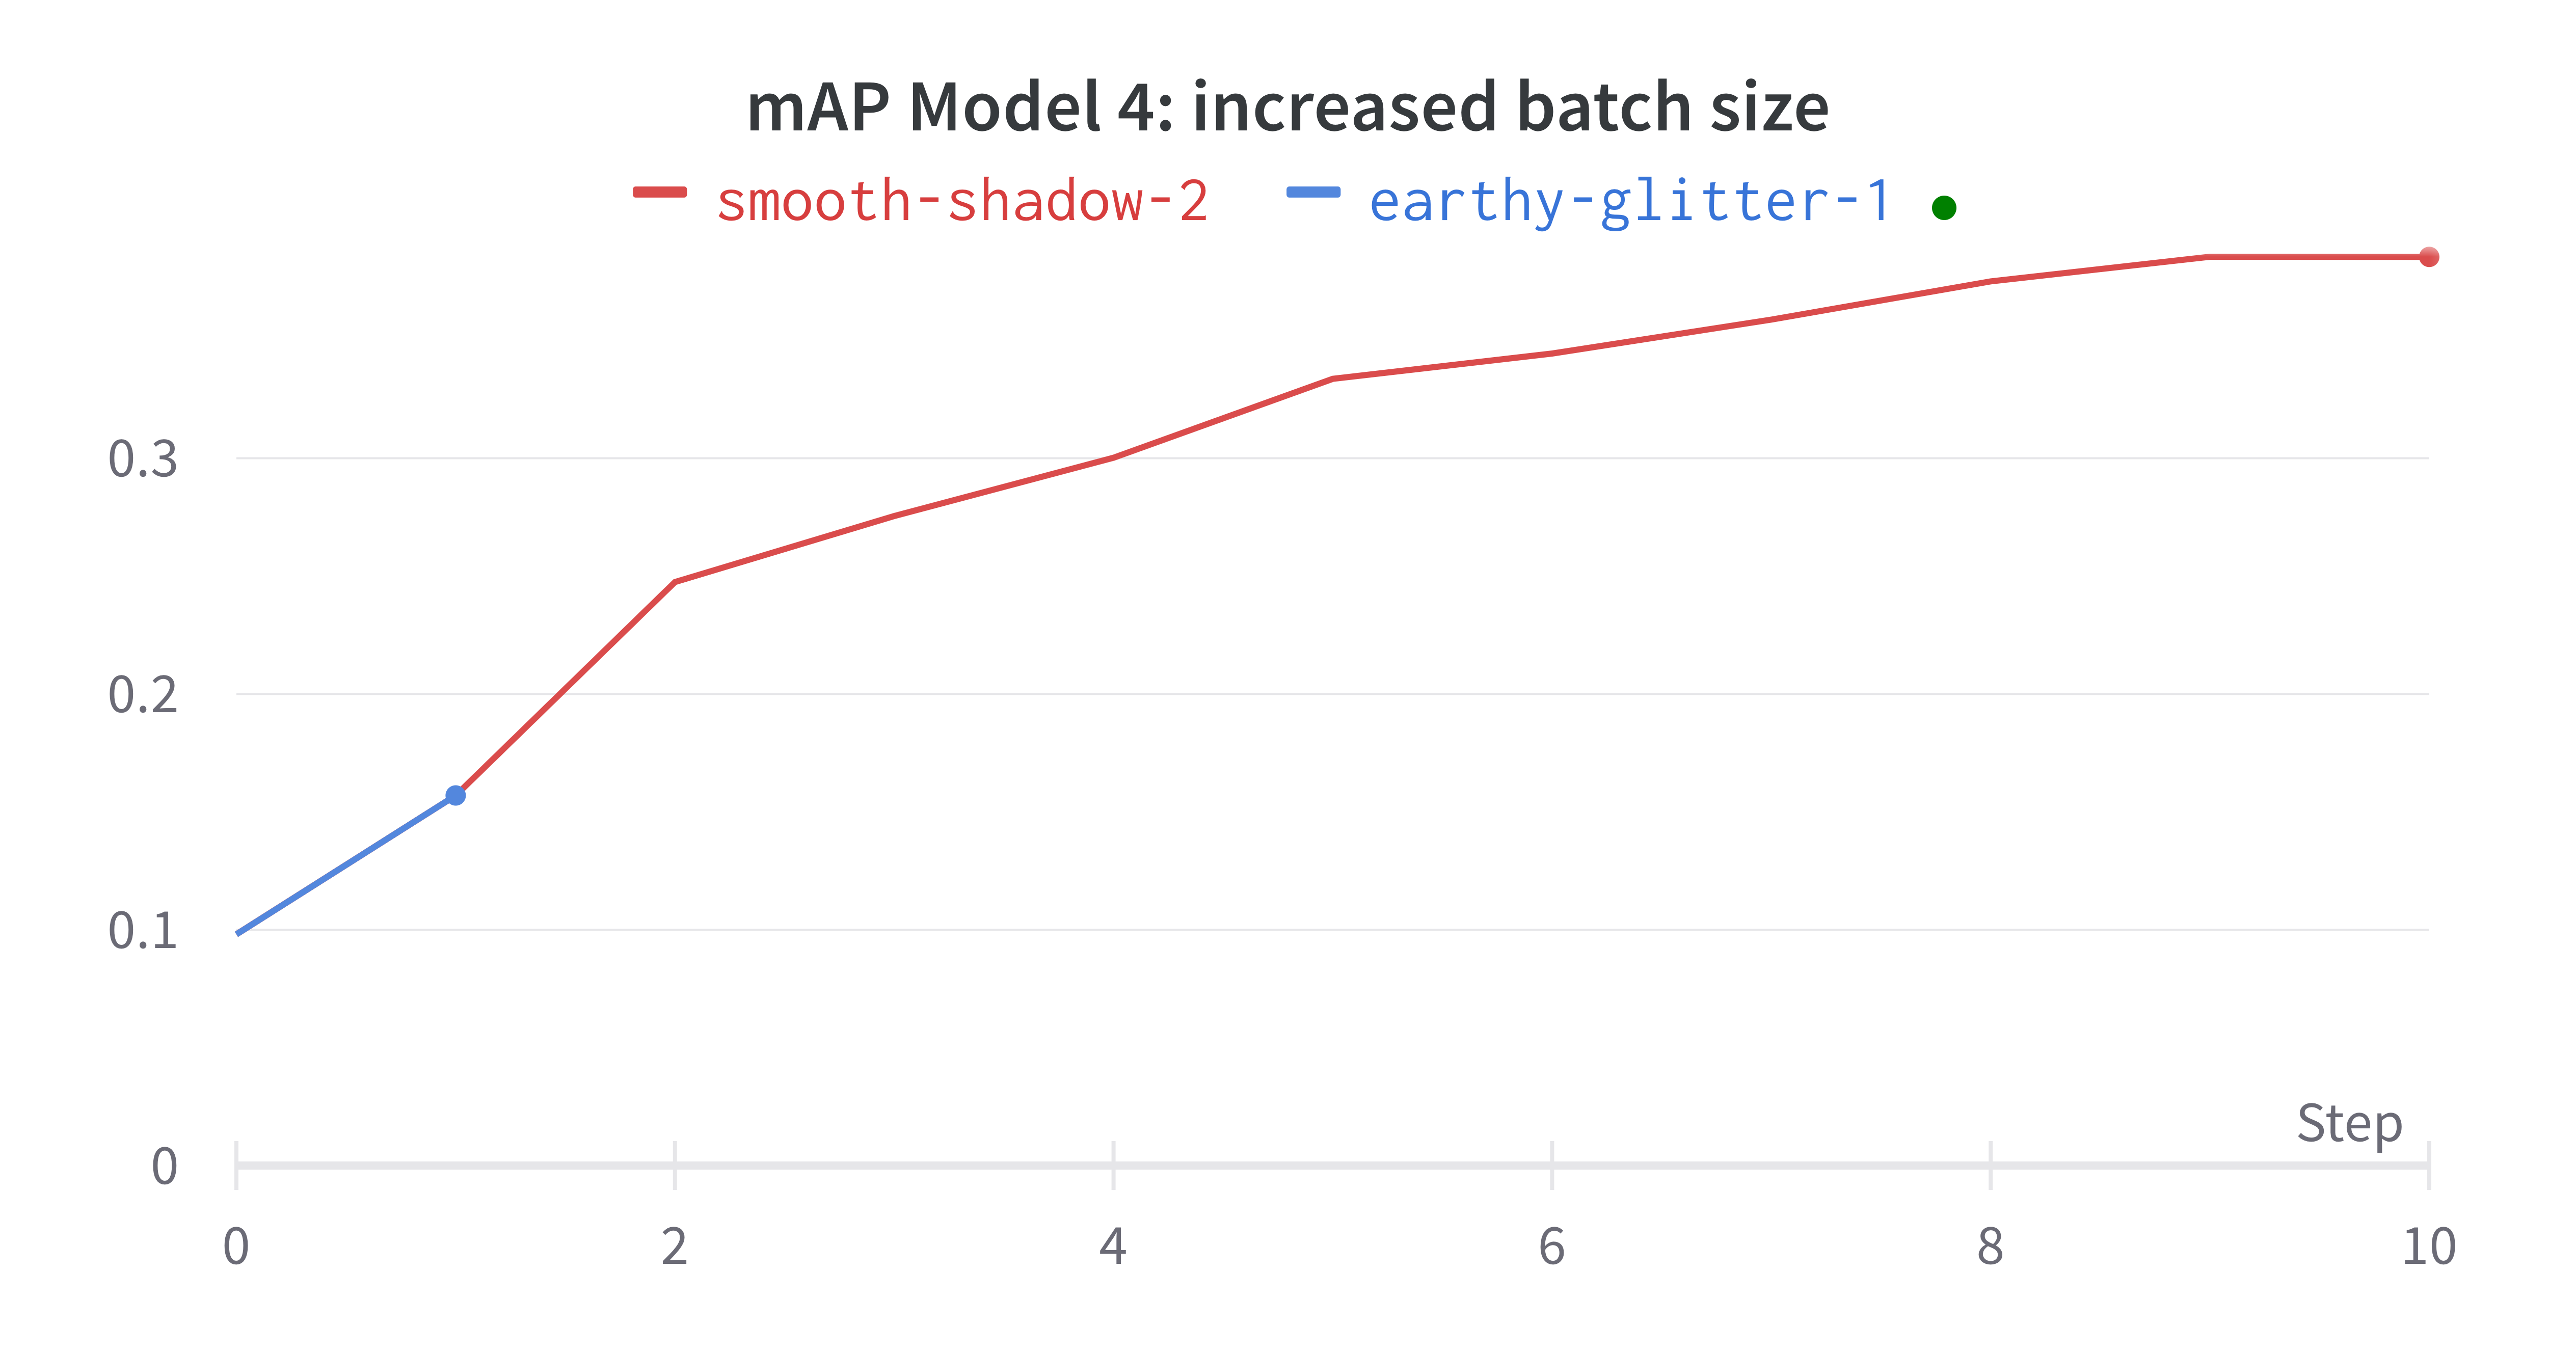

*Опять метрика не увеличилась, к тому же видно что во всех случаях с 8 эпохи изменения совсем небольшие. Попробую конфигурацию с большей аугментацией*

In [ ]:
!python /kaggle/working/yolov5/train.py --img 1024 \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --project helmet_detection_aug \
                 --save-period 1 \
                 --device=0 \
                 --hyp /kaggle/working/yolov5/data/hyps/hyp.scratch-med.yaml

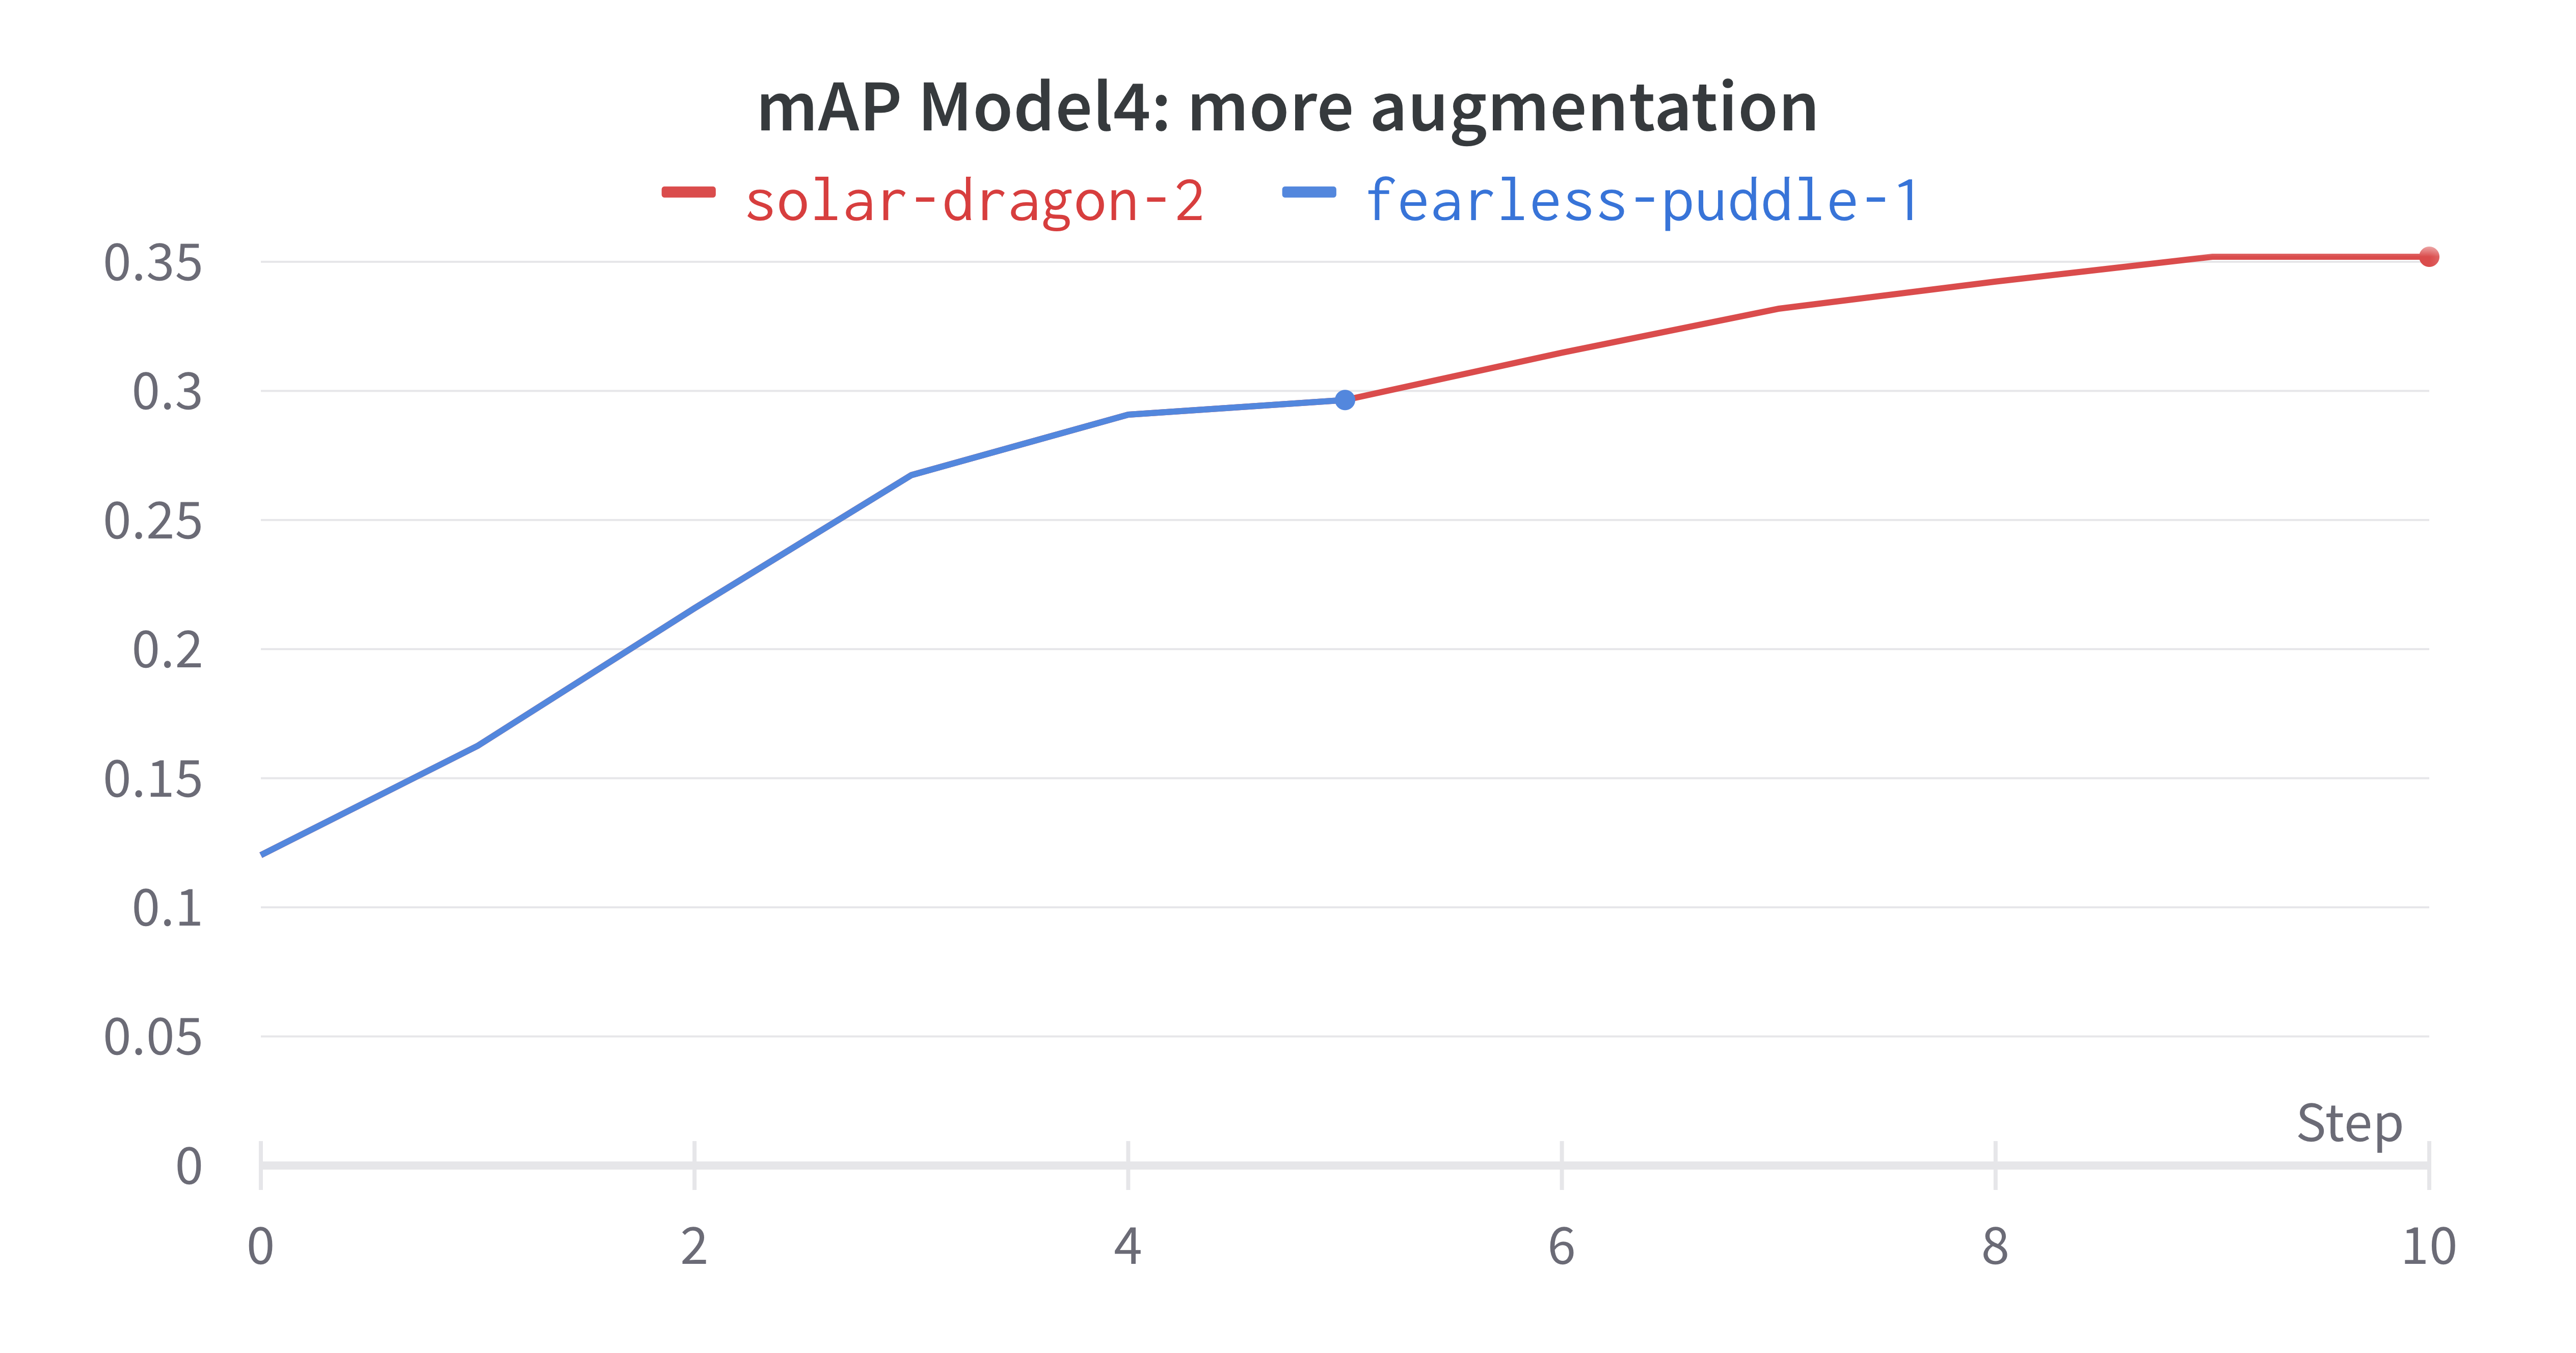

***mAP на 10 эпохе: 0.352***
*Попробую обучить модель с еще большим размером изображения, на большее количество эпох*

In [ ]:
!python /kaggle/working/yolov5/train.py --img 1280 \
                 --epochs 30 \
                 --data data.yaml2 \
                 --weights yolov5s.pt \
                 --project helmet_detection_more \
                 --save-period 1

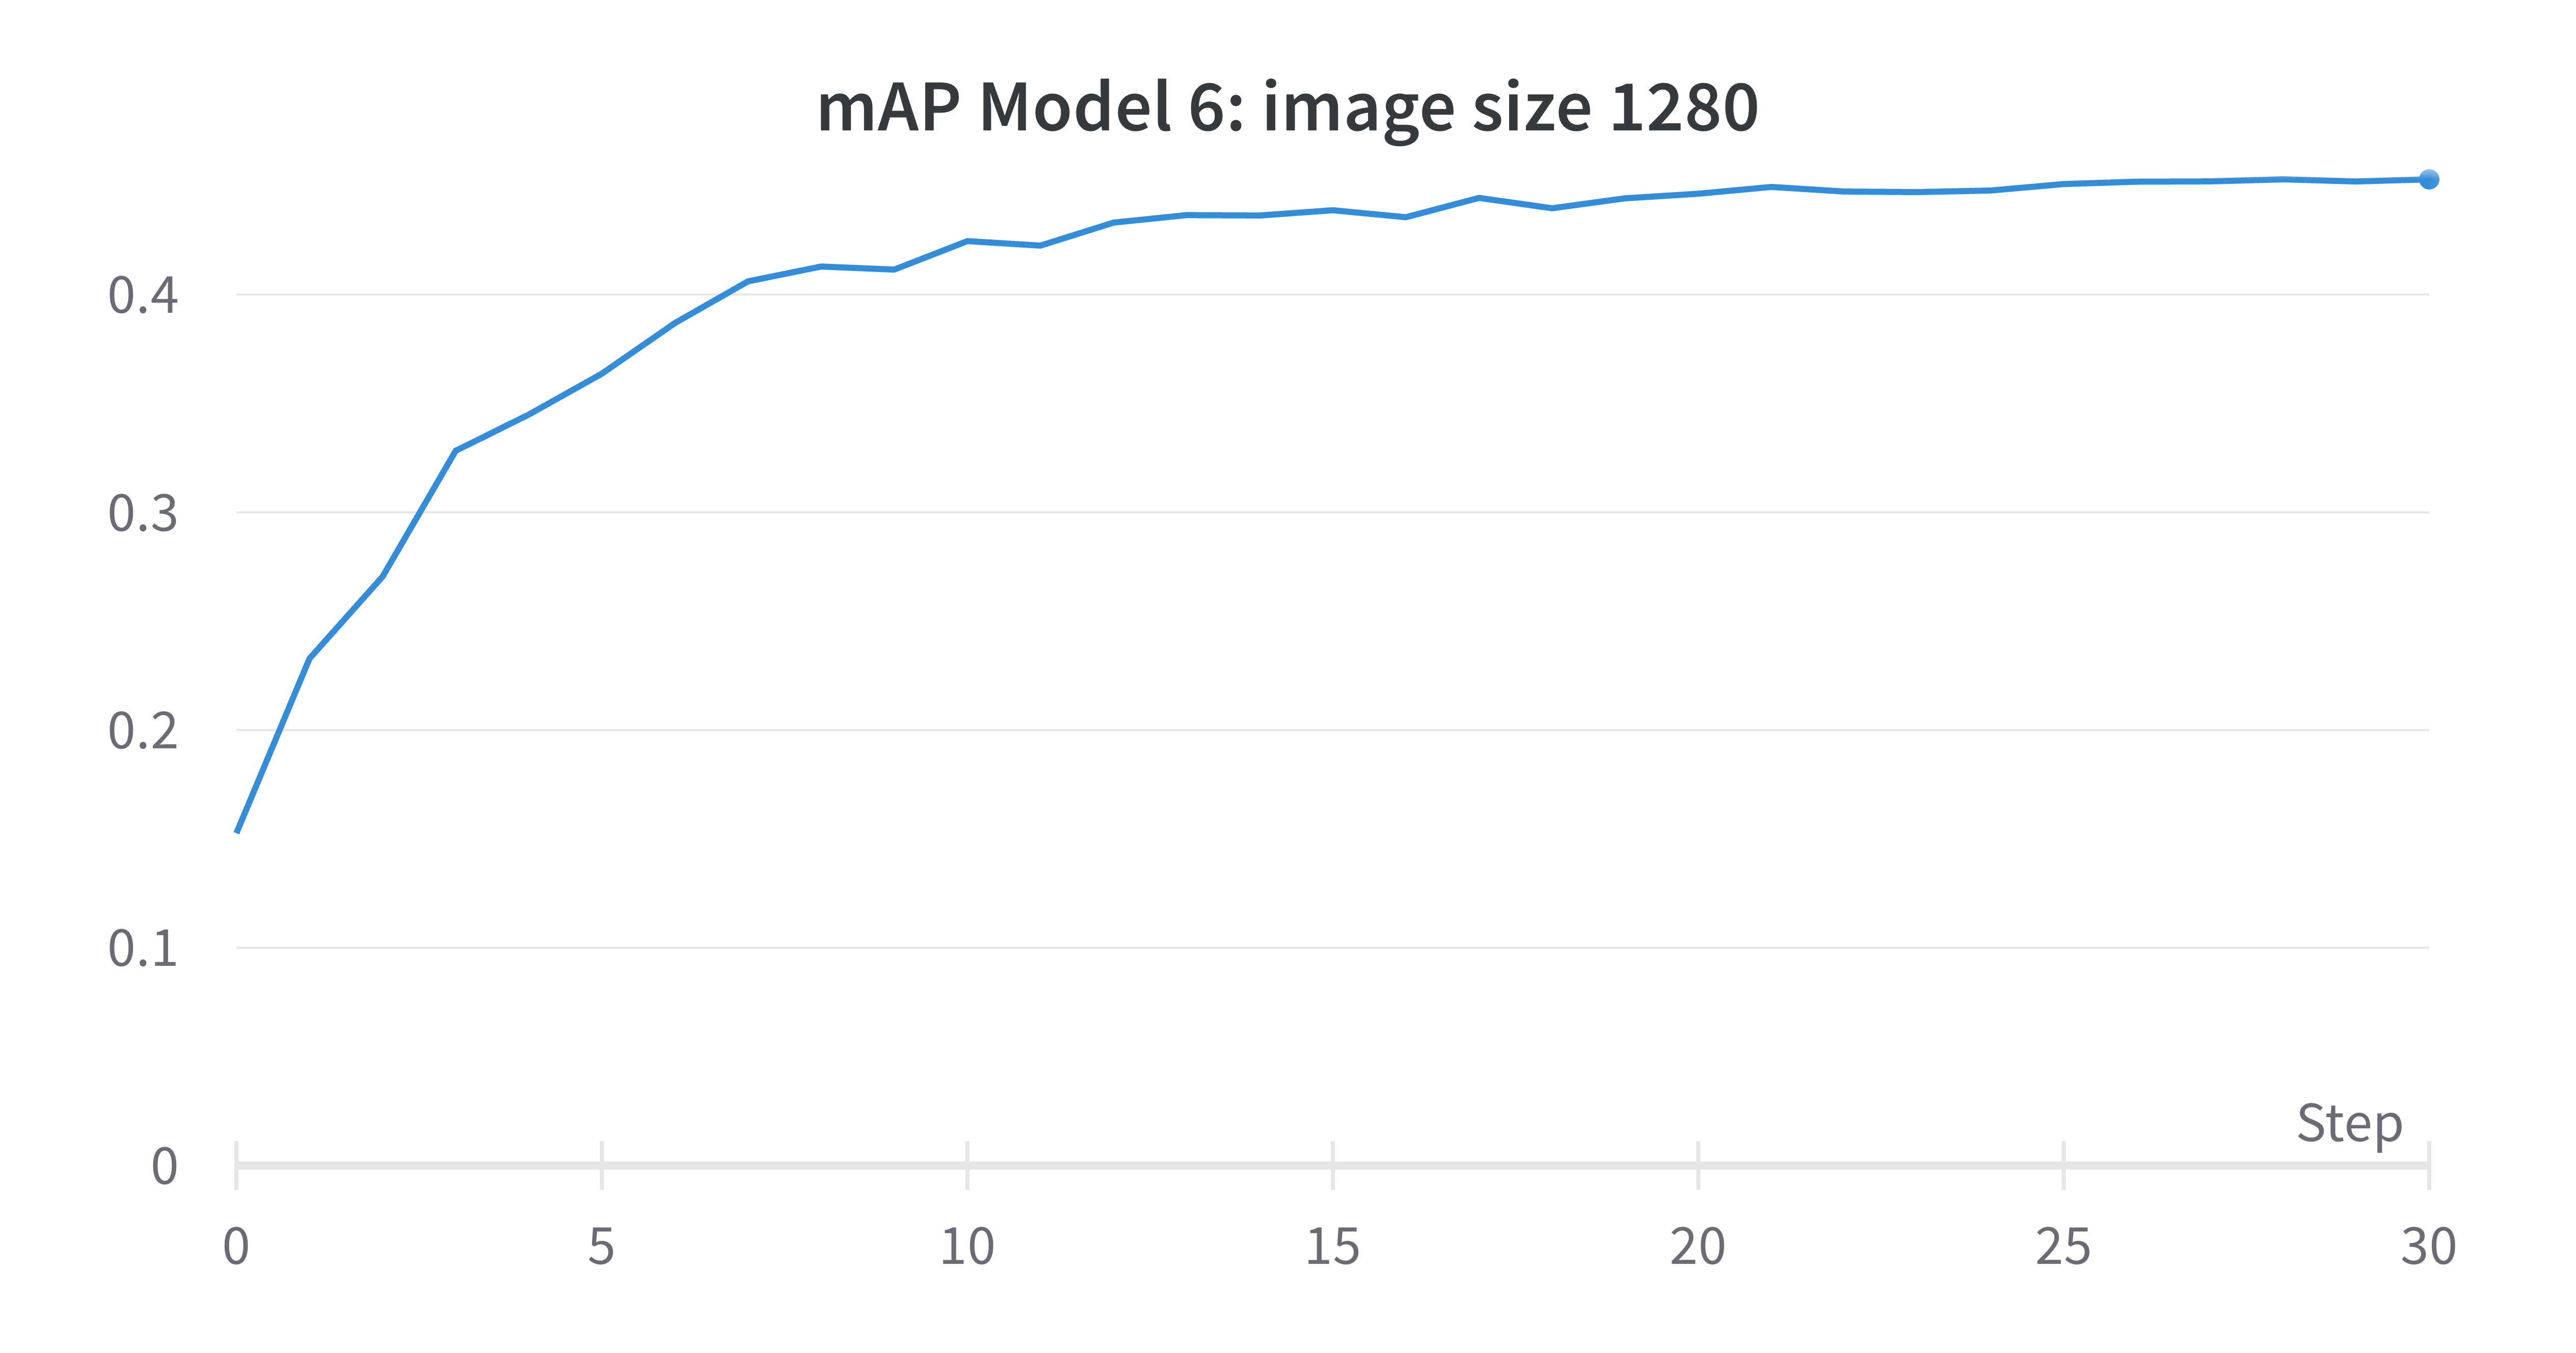

*Получилось добиться значения* ***mAP=0.45***. *Выберу эту модель как финальную*

*Применение модели:*

In [67]:
!python /kaggle/working/yolov5/detect.py --weights /kaggle/working/helmet_detection_final/exp/weights/best.pt --source \
/kaggle/working/tmp/yolo_workdir/images/valid/57822_003241_Sideline_frame0603.jpg

detect: weights=['/kaggle/working/helmet_detection_final/exp/weights/best.pt'], source=/kaggle/working/tmp/yolo_workdir/images/valid/57822_003241_Sideline_frame0603.jpg, data=../../../../yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../../../yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: YOLOv5 requirement "tqdm>=4.64.0" not found, attempting AutoUpdate...

requirements: 1 package updated per /kaggle/working/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-116-g5c91dae Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradient

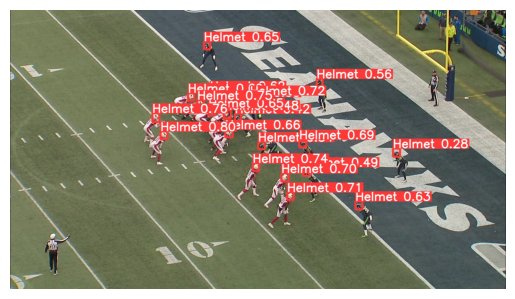

In [80]:
img = Image.open('/kaggle/working/yolov5/runs/detect/exp6/57822_003241_Sideline_frame0603.jpg')
plt.imshow(img)
plt.axis('off');

*Создание фреймов из видео и применение модели*

In [66]:
def make_frames(video_path, output_dir_name):
    cap = cv2.VideoCapture(video_path)

    if not os.path.exists(output_dir_name):
        os.makedirs(output_dir_name)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        frame_path = f"{output_dir_name}/frame{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)

    cap.release()   

In [ ]:
make_frames(
    '/kaggle/input/nfl-health-and-safety-helmet-assignment/train/57583_000082_Sideline.mp4',
    'frames_1'   
)

In [ ]:
!python /kaggle/working/yolov5/detect.py --weights /kaggle/input/bestpt/best.pt --source \
/kaggle/working/frames_1 --project frames_1_out

*Код для склеивания фреймов с предска в видео*

In [ ]:
img_dir_path = "/kaggle/working/frames_1_out/exp"
video_name = "output.avi"
fps = 30

img_names = os.listdir(img_dir_path)
img_names.sort()

img = cv2.imread(os.path.join(img_dir_path, img_names[0]))
height, width, channels = img.shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

for img_name in img_names:
    img_path = os.path.join(img_dir_path, img_name)
    img = cv2.imread(img_path)
    video_writer.write(img)

video_writer.release()

*Прикрепить видео к ноутбуку не получается, иначе он будет слишком тяжелый для бота. Но получается классный видосик где есть трекинг шлемов. Прикрепляю его отдельным файлом*

*Аналогично можно получить фреймы и предсказания на них для любого видео:*

In [ ]:
make_frames(
    '/kaggle/input/nfl-health-and-safety-helmet-assignment/train//kaggle/input/nfl-health-and-safety-helmet-assignment/train/57586_004152_Endzone.mp4',
    'frames_2'   
)

!python /kaggle/working/yolov5/detect.py --weights /kaggle/input/bestpt/best.pt --source \
/kaggle/working/frames_2 --project frames_2_out

*Вывод: модель получилась лучше, чем опубликованная на kaggle - у автора mAP вышла около 0.35, у меня же получилось довести до 0.45. State-of-the-art CV модели имеют значение mAP 0.8, значит для начала точность весьма не плоха. Точность предсказания оказалась выше прежде всего за счет увеличения разрешения картинки. В данном случае это важный параметр, так как шлемы по сравнению с остальной картинкой очень маленькие. Остальные гиперпараметры или изменение оптимизатора результат не улучшали* 